In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

import importlib, numba, copy, os, pickle, resource, numpy as np
from sys import path

from scipy.sparse.linalg import lgmres
from scipy.sparse import diags, save_npz, load_npz
from scipy.io import readsav

from astropy.io import fits

import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 20}) # Make the fonts in figures big enough for papers
plt.rcParams.update({'figure.figsize':[20,20]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=160)

base_path = os.path.dirname(os.getcwd()) # Sets base path to current parent directory
data_path = os.path.join(base_path,'data')
output_path = os.path.join(base_path,'output')

# Add the path to the SHARPESST modules to the current path. Not needed if the modules
# are installed to the current Python environment, see readme.
sharpesst_path = os.path.join(base_path)
path.append(sharpesst_path) 

from sharpesst.util import bindown, as_dict, get_iris_data, masked_median_filter, get_mask_errs
from sharpesst.coord_transform import coord_transform, trivialframe
from sharpesst.element_grid import detector_grid, source_grid
from sharpesst.coord_grid import coord_grid
from sharpesst.fit_spice_lines import get_overall_center, fit_spice_lines as fsl
from sharpesst.correct_2d_psf import correct_spice_raster, correct_spice_fits
print(base_path)

/home/jplowman/research/solar_physics/projects/spice_psf/SHARPESST


In [2]:
spice_filename = 'example_raster_20221018T140259_V02_150995354-032.fits'

corrected_filename = 'psf_corrected_'+spice_filename
spice_fullname = os.path.join(data_path, spice_filename)
corrected_fullname = os.path.join(data_path, corrected_filename)

pxsz_mu, arcsperpx, angsperpx = 18, 1.1, 0.09 # microns per pixel, arcseconds per pixel. angstrom per pixel
platescale_x, platescale_y, platescale_l = pxsz_mu/np.array([arcsperpx,arcsperpx,angsperpx])

yl_core_xpo = 2.0
fwhm_core0_yl = np.array([2.0, 1.05])
gaussian_desc = 'Mod. Gaussian core: broad peak, narrow shoulder'+'; spatial average (lower half of slit)'

fwhm_wing0_yl = np.array([10.0, 2.0]) # Nominal values from Hardi
desc_str='; standard wing aspect ratio'
psf_yl_angle = -15*np.pi/180
wing_weight = 0.165

spice_err_fac = 0.2 # Rough guess for the DN to count conversion and read noise level in SPICE

rebin_facs = [1,2,1]

In [3]:
hdul = fits.open(spice_fullname)
hdul.info() # Show what rasters are in the file
# Check for obs_hdu = 1 (or set) to see which are valid data...
hdul.close()

Filename: /home/jplowman/research/solar_physics/projects/spice_psf/SHARPESST/data/example_raster_20221018T140259_V02_150995354-032.fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  O VI 1032 (Merged)    1 PrimaryHDU     393   (128, 830, 31, 1)   float32   


In [5]:
hdr_exten = 0
hdul = fits.open(spice_fullname)
spice_dat0, spice_hdr = hdul[hdr_exten].data[0], hdul[hdr_exten].header
hdul.close()

In [7]:
# Remove the minimum at each pixel along the scan dimension to further correct for dark offset errors, etc:
spice_dat = copy.deepcopy(spice_dat0)
specmin = np.nanmin(spice_dat0,axis=2)
nl = spice_dat.shape[2]
for i in range(0,nl): spice_dat[:,:,i] -= specmin # np.nanmedian(specmin,axis=0) #
# Warning about all-NaN slice is expected...

/tmp/ipykernel_483189/3775911095.py:3: RuntimeWarning: All-NaN slice encountered
  specmin = np.nanmin(spice_dat0,axis=2)


In [8]:
dx, dy, dl = spice_hdr['CDELT1'], spice_hdr['CDELT2'], spice_hdr['CDELT3']
nl, ny, nx = spice_dat.shape # Yes, the order of axes in the data array doesn't match the CDELTs
print('dx = ', dx, 'dy = ', dy, 'dl = ', dl)
print('nx = ', nx, 'ny = ', ny, 'nl = ', nl)

bin_facs = np.array([spice_hdr['NBIN1'],spice_hdr['NBIN2'],spice_hdr['NBIN3']])

dx =  4.0 dy =  1.098 dl =  0.019246
nx =  128 ny =  830 nl =  31


[Text(0.5, 1.0, 'min along scan axis subtracted'),
 Text(0.5, 0, 'Scan position'),
 Text(0, 0.5, 'Scan equivalent slit position')]

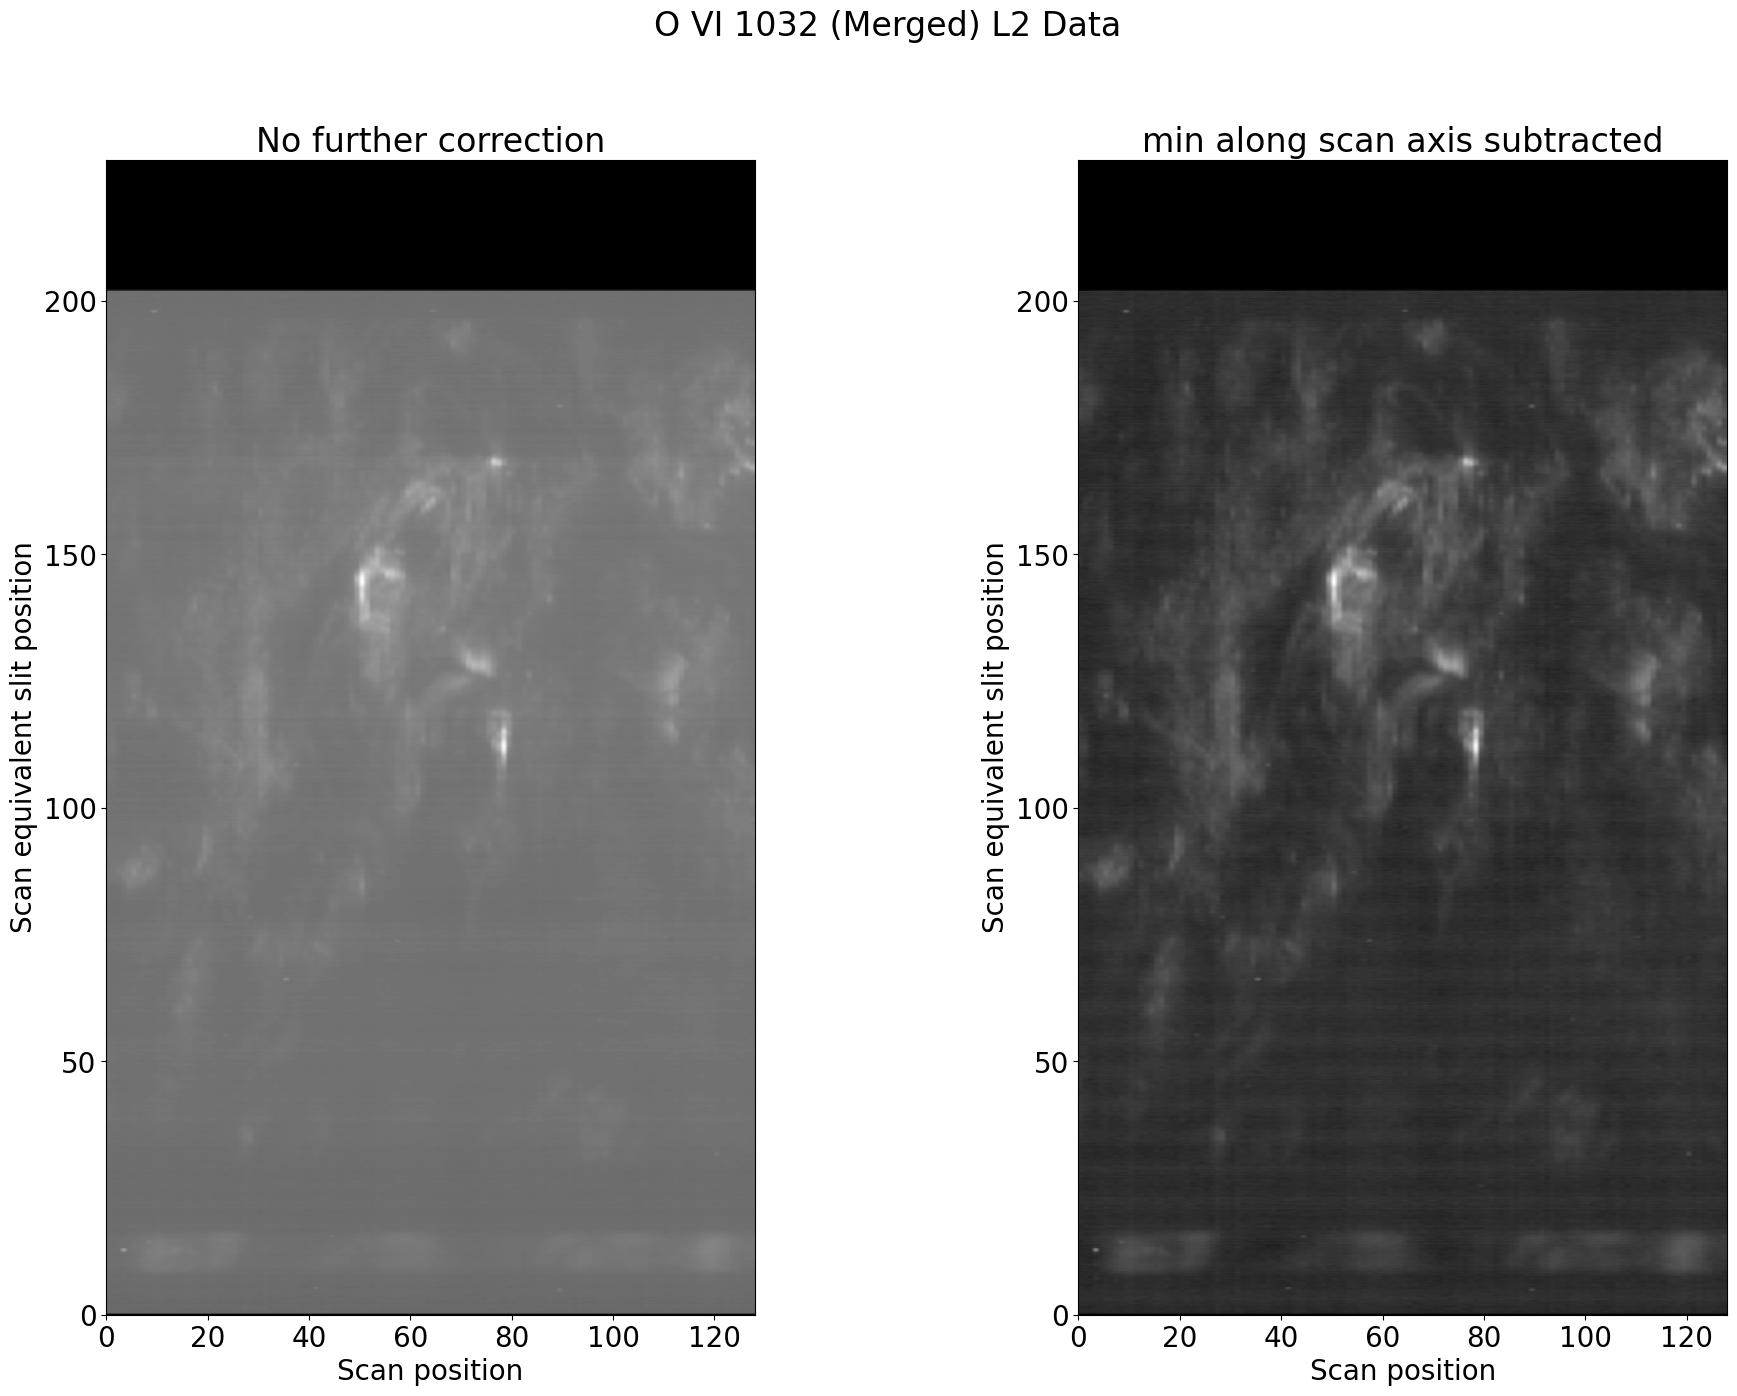

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[23,15])

plt.suptitle(spice_hdr['EXTNAME'] + ' L2 Data')

axes[0].imshow(np.nansum(spice_dat0,axis=0)**(1.0/2.2),extent=[0,nx, 0,ny*dy/dx], cmap=plt.get_cmap('gray'))
axes[0].set(title='No further correction', xlabel='Scan position', ylabel='Scan equivalent slit position')

axes[1].imshow(np.nansum(spice_dat,axis=0)**(1.0/2.2),extent=[0, nx, 0, ny*dy/dx],  cmap=plt.get_cmap('gray'))
axes[1].set(title='min along scan axis subtracted', xlabel='Scan position', ylabel='Scan equivalent slit position')
# Some vertical ripple left in the data, not sure how to remove it...

In [10]:
# Bin down the data to increase SNR
spicedat_bindown = bindown(spice_dat,np.round(np.array(spice_dat.shape)/rebin_facs).astype(np.int32))
print(spicedat_bindown.shape)

(31, 415, 128)


0.269197188426323


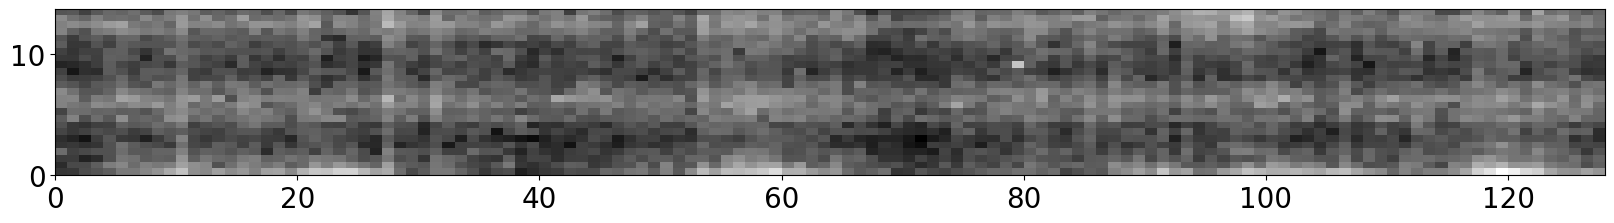

In [11]:
# Use data from the spot between the dumbbell and the main image to estimate the noise level
plt.imshow((np.nansum(spicedat_bindown[:,30:55,:],axis=0)**(1.0/2.2)),extent=[0, nx, 0, 50*dy/dx],  cmap=plt.get_cmap('gray'))

spice_err_fac = np.nanstd(spicedat_bindown[:,30:55,:])
#spice_dat -= np.nanmedian(spice_dat[:,60:110,:])
print(spice_err_fac)

In [12]:
# There's still some offset, use the are between dumbbell and main image to estimate and remove it.
spicedat_bindown -= np.nanmedian(spicedat_bindown[:,30:55,:])

[Text(0.5, 0, 'Position along slit in unbinned pixels (vertical axes same)')]

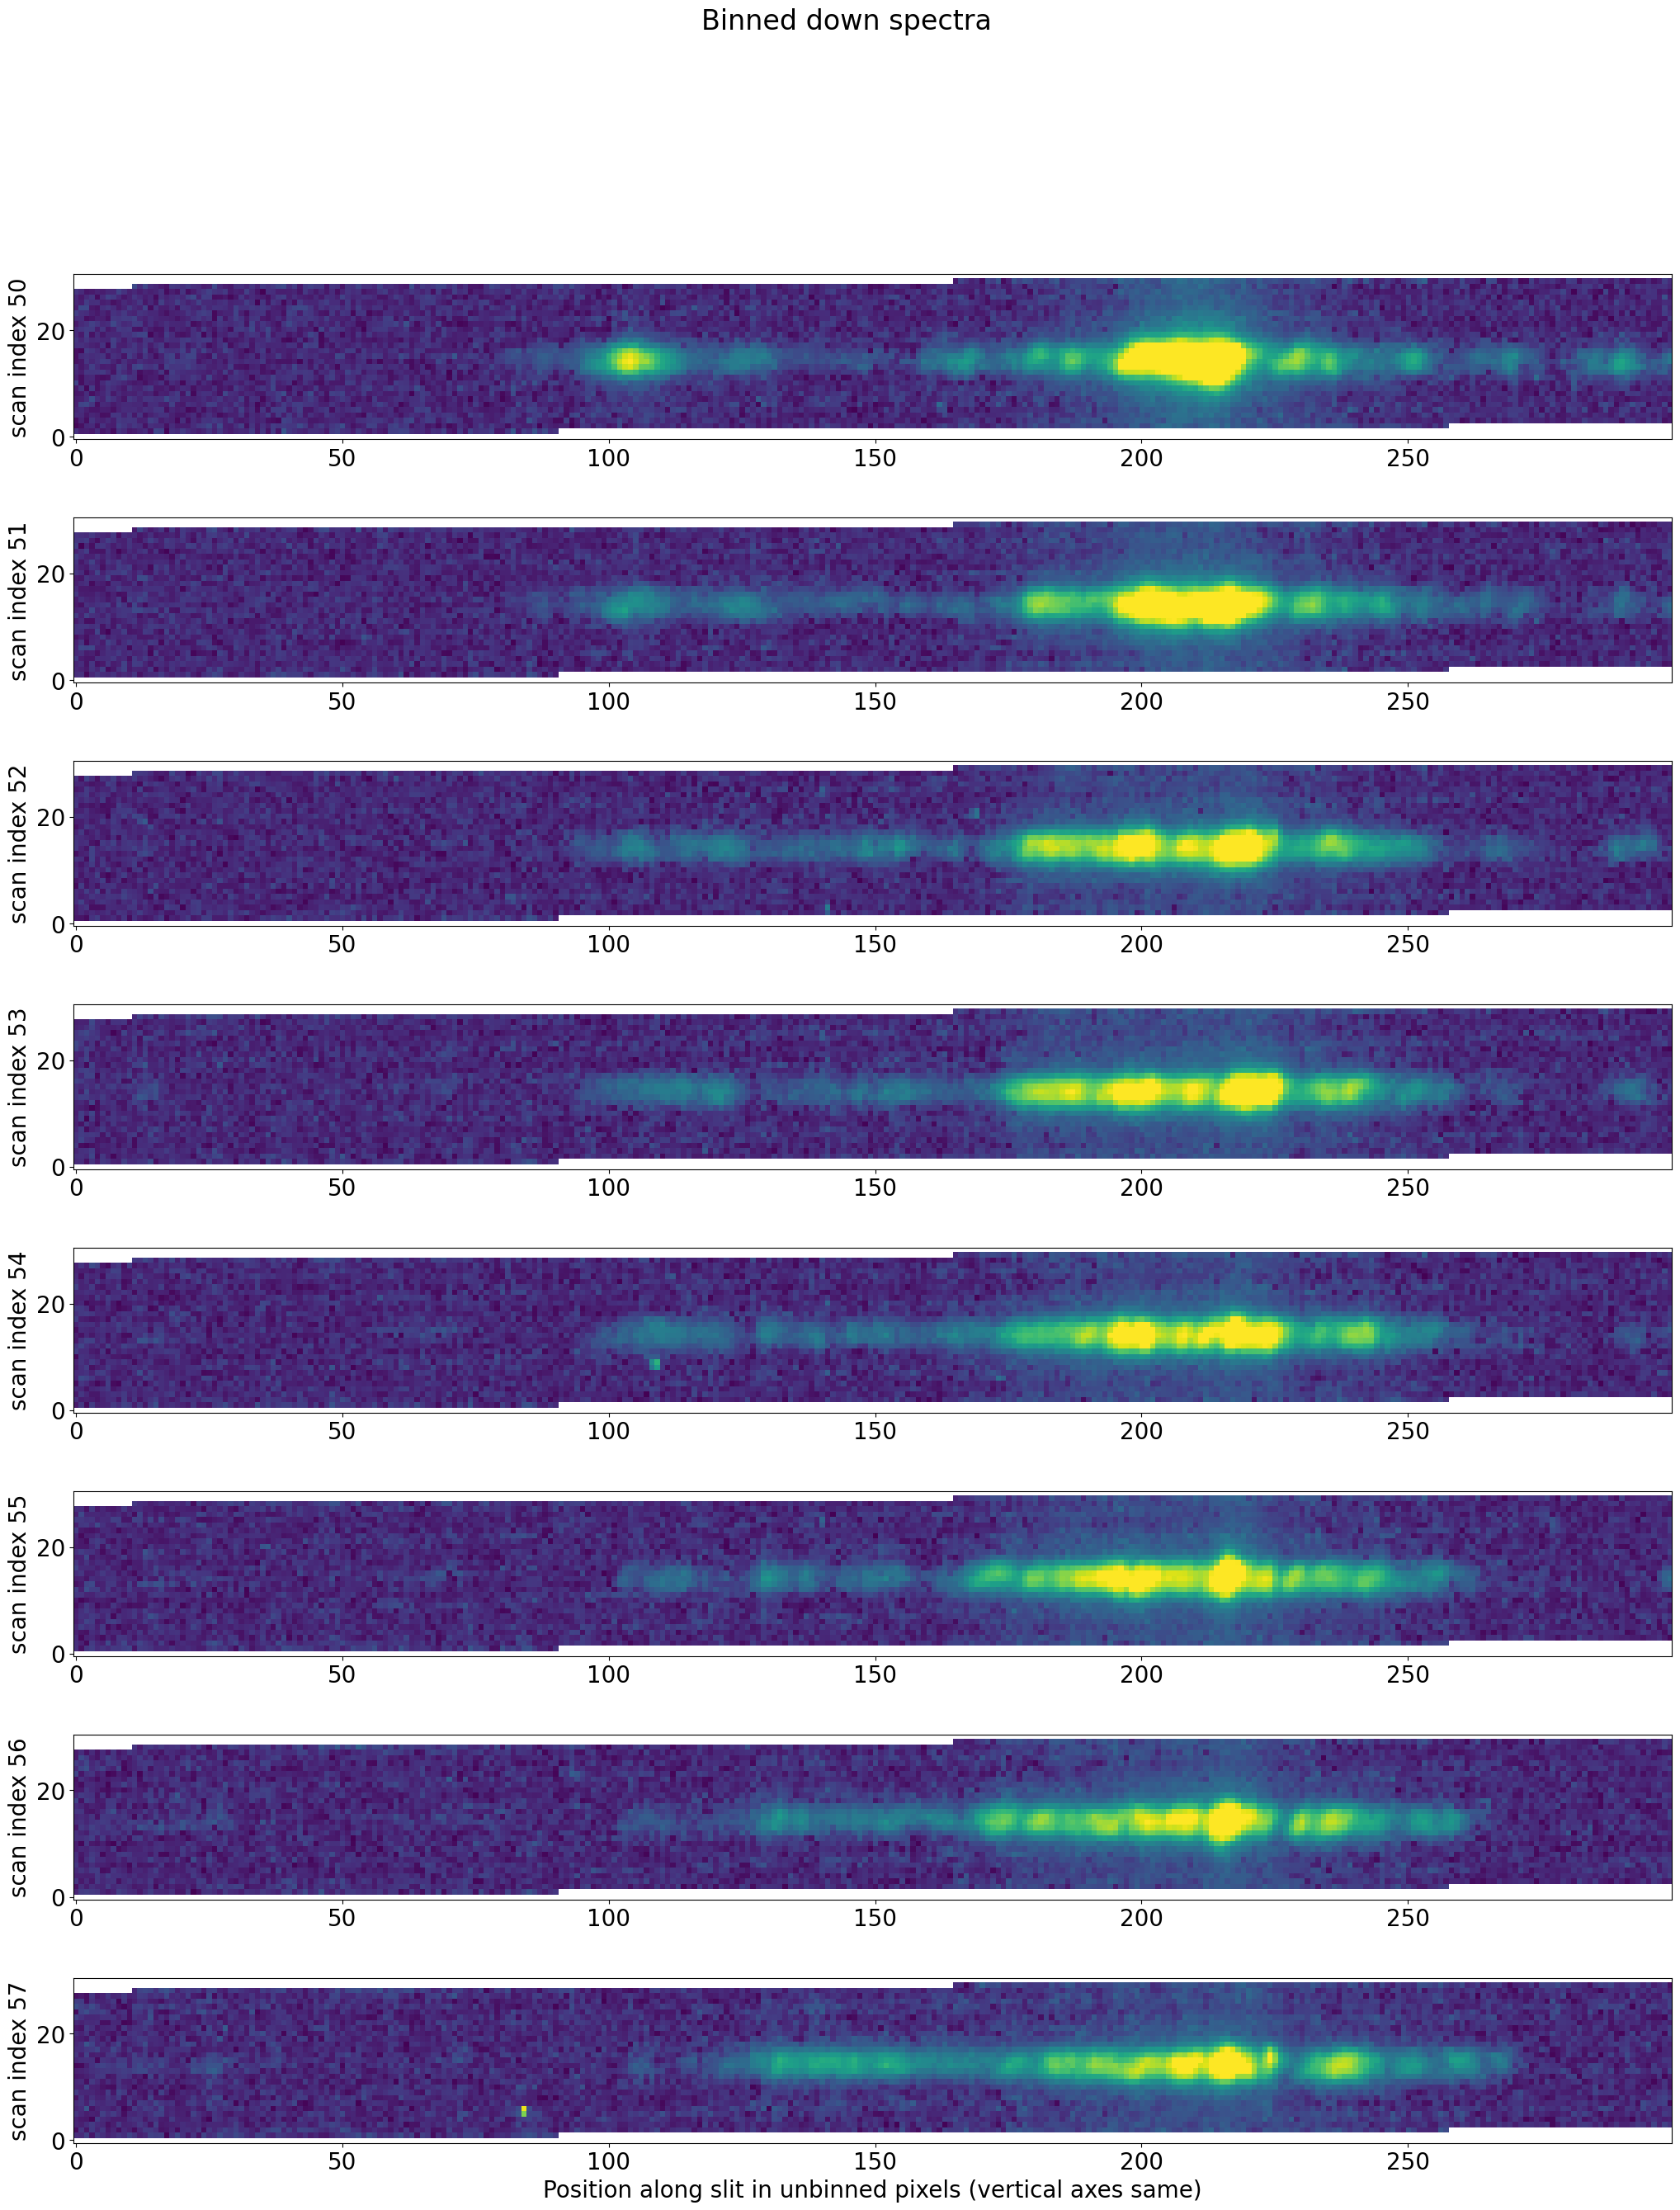

In [13]:
#Plot the spectra at various locations in the scan:
fig, axes = plt.subplots(nrows=8,ncols=1,figsize=[25,30])
plt.suptitle('Binned down spectra')
for i in range(0,8):
    ii = i+50
    axes[i].imshow(np.abs(spicedat_bindown[:,50:350,ii])**(1.0/2.2), vmin=0,vmax=20**(1.0/2.2))
    axes[i].set(ylabel='scan index '+str(ii))
axes[i].set(xlabel='Position along slit in unbinned pixels (vertical axes same)')

In [14]:
# This exponent sets the non-gaussianity of the PSF core, 1 = Gaussian
# It also also changes its width somewhat, which is not ideal...
yl_core_xpo = 1.0

# Rotation angle of the PSF, both core and wings
psf_yl_angle = -13*np.pi/180

# FWHMs of PSF core. First argument is width along y axis before rotation,
# and is in arcseconds. Second is along lambda axis and is in angstrom.
fwhm_core0_yl = np.array([5.5, 1.15])

# This descriptor for plots should be manually edited to reflect the PSF parameters
gaussian_desc = '2-part Gaussian PSF'

fwhm_wing0_yl = np.array([20.0, 4]) # FWHMs of PSF wings in arcseconds and angstroms, respectively
desc_str='; standard wing aspect ratio'

# Fraction of overall PSF amplitude in wings (core weight is 1.0 - wing_weight).
# PSFs have unit peak amplitude, -- PLEASE NOTE: they do not integrate to 1.
wing_weight = 0.21

spice_dat1 = copy.deepcopy(spicedat_bindown).transpose([2,1,0]).astype(np.float32)

In [15]:
from sharpesst.correct_2d_psf import get_fwd_matrices, correct_spice_raster

In [16]:
amat_yl_core, amat_yl_wing, amat_yl_symm, amat_yl, metadict = get_fwd_matrices(spice_dat1, spice_hdr, fwhm_core0_yl, fwhm_wing0_yl, psf_yl_angle, wing_weight, super_fac=1, psf_thold_core=0.0005, spice_bin_facs = rebin_facs)

Correcting O VI 1032 (Merged); ref. wavelength=1028.27521
Computing PSF Core:
4.990671641791045 % done after 0.372896671295166 seconds
9.989116915422885 % done after 0.73671555519104 seconds
14.987562189054726 % done after 1.1009564399719238 seconds
19.98600746268657 % done after 1.4607739448547363 seconds
24.984452736318406 % done after 1.8255631923675537 seconds
29.982898009950247 % done after 2.1871535778045654 seconds
34.98134328358209 % done after 2.546306848526001 seconds
39.97978855721393 % done after 2.9153804779052734 seconds
44.978233830845774 % done after 3.2978031635284424 seconds
49.97667910447761 % done after 3.6605288982391357 seconds
54.975124378109456 % done after 4.063446044921875 seconds
59.97356965174129 % done after 4.43862771987915 seconds
64.97201492537313 % done after 4.804953098297119 seconds
69.97046019900498 % done after 5.393125534057617 seconds
74.96890547263682 % done after 5.753600358963013 seconds
79.96735074626865 % done after 6.1153953075408936 seconds

[Text(0.5, 1.0, 'Real spectra for comparison'),
 Text(0, 0.5, 'wavelength pixel'),
 Text(0.5, 0, 'pixels along slit (binned down)')]

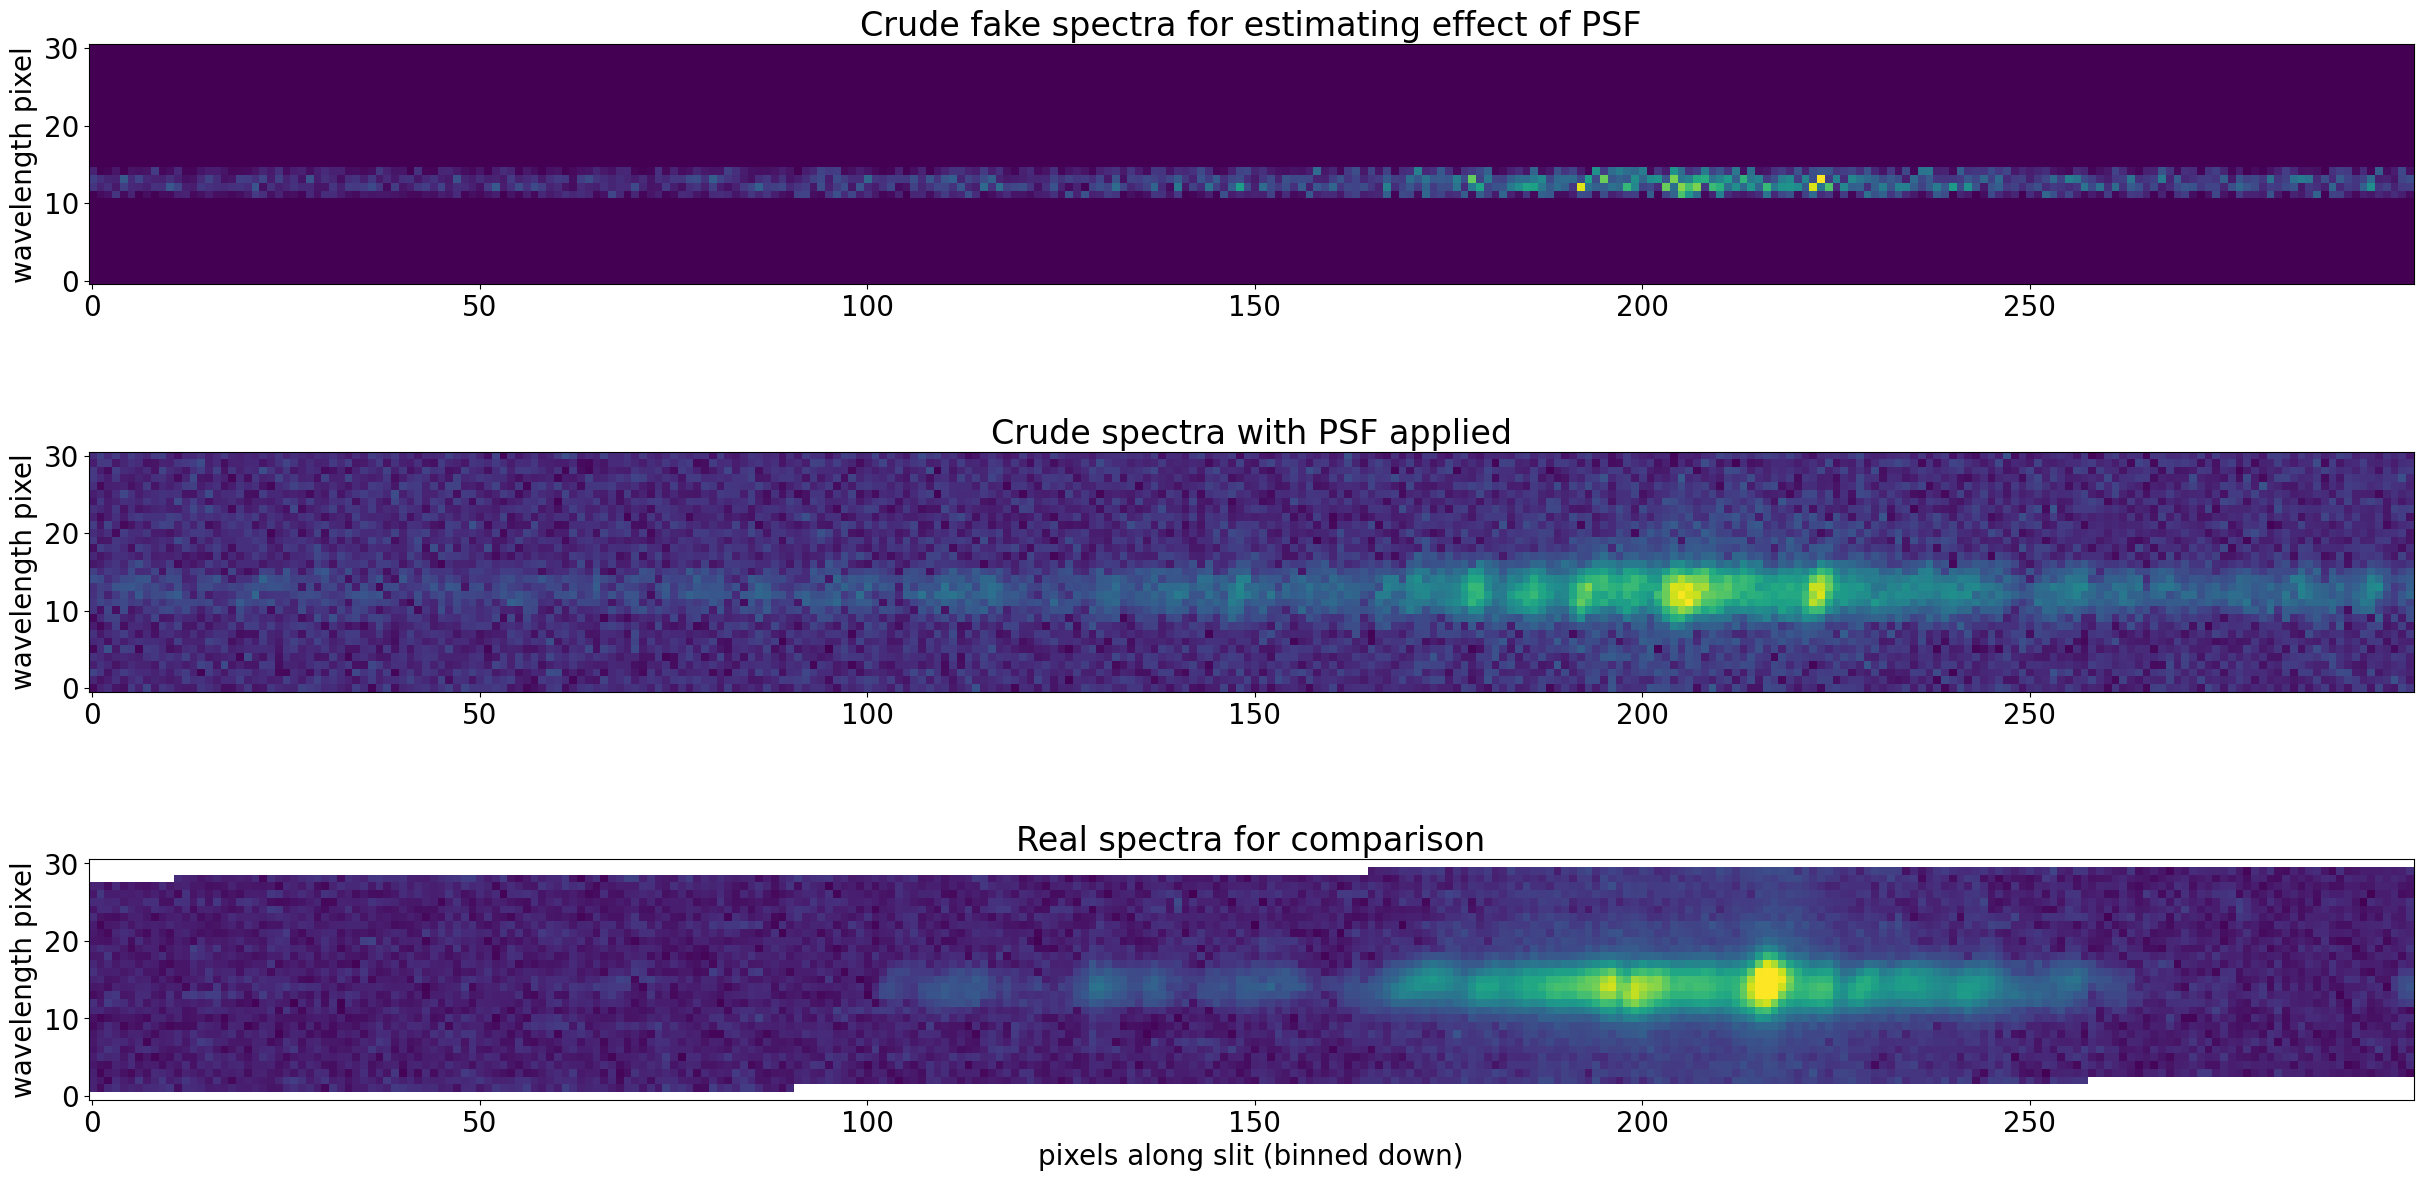

In [17]:
# Make a crude fake spectra to help estimate the effect of the PSF:
example_src = np.zeros(spice_dat1.shape[1:])
example_src[:,11] = 0.5*np.abs(np.random.normal(size=spice_dat1.shape[1]))**2
example_src[:,12] = np.abs(np.random.normal(size=spice_dat1.shape[1]))
example_src[:,13] = np.abs(np.random.normal(size=spice_dat1.shape[1]))
example_src[:,12] += 0.5*np.abs(np.random.normal(size=spice_dat1.shape[1]))**3
example_src[:,13] += 0.5*np.abs(np.random.normal(size=spice_dat1.shape[1]))**3
example_src[:,14] = 0.5*np.abs(np.random.normal(size=spice_dat1.shape[1]))**2

for i in range(0,example_src.shape[0]): example_src[i,:] *= 1/np.sqrt(1+((i-260)/7)**2)

# Apply the PSF to it:
simdat = 2*(amat_yl*example_src.flatten()).reshape(spice_dat1.shape[1:]).T
simerr = spice_err_fac*np.random.normal(size=simdat.shape) + np.random.normal(size=simdat.shape)*spice_err_fac*(simdat**0.5)

# Make plots:

fig, axes = plt.subplots(nrows=3,ncols=1,figsize=[30,15])

axes[0].imshow(example_src.T[:,50:350]**(1.0/2.2))
axes[0].set(title='Crude fake spectra for estimating effect of PSF', ylabel='wavelength pixel')

axes[1].imshow(np.abs(simdat+simerr)[:,50:350]**(1.0/2.2), vmin=0,vmax=20**(1.0/2.2))
axes[1].set(title='Crude spectra with PSF applied', ylabel='wavelength pixel')

axes[2].imshow(np.abs(spice_dat1[55,50:350,:]).T**(1.0/2.2), vmin=0,vmax=40**(1.0/2.2))
axes[2].set(title='Real spectra for comparison', ylabel='wavelength pixel', xlabel='pixels along slit (binned down)')

In [18]:
# Apply the correction. Chi squared threshold of 0.5 is approximate. This
# version of the correction uses an ad hoc estimate for errors levels. If these
# are updated with more official quantative error estimates, chi2_th should likely
# be changed to 1.0:
spice_corr_dat, spice_corr_chi2s, metadict = correct_spice_raster(spice_dat1, spice_hdr, fwhm_core0_yl, fwhm_wing0_yl, 
                                                                  psf_yl_angle, wing_weight, super_fac=1, chi2_th = 0.5,
                                                                  psf_thold_core=0.0005, spice_bin_facs = rebin_facs)

Correcting O VI 1032 (Merged); ref. wavelength=1028.27521
Computing PSF Core:
4.990671641791045 % done after 0.4380974769592285 seconds
9.989116915422885 % done after 0.8440899848937988 seconds
14.987562189054726 % done after 1.2459876537322998 seconds
19.98600746268657 % done after 1.6542840003967285 seconds
24.984452736318406 % done after 2.0602927207946777 seconds
29.982898009950247 % done after 2.4630441665649414 seconds
34.98134328358209 % done after 2.8663177490234375 seconds
39.97978855721393 % done after 3.2709529399871826 seconds
44.978233830845774 % done after 3.672537326812744 seconds
49.97667910447761 % done after 4.073378086090088 seconds
54.975124378109456 % done after 4.477191686630249 seconds
59.97356965174129 % done after 4.8797948360443115 seconds
64.97201492537313 % done after 5.279433250427246 seconds
69.97046019900498 % done after 5.917383193969727 seconds
74.96890547263682 % done after 6.3144683837890625 seconds
79.96735074626865 % done after 6.715557813644409 sec

[Text(0.5, 1.0, 'Example corrected spectra'),
 Text(0, 0.5, 'wavelength pixels')]

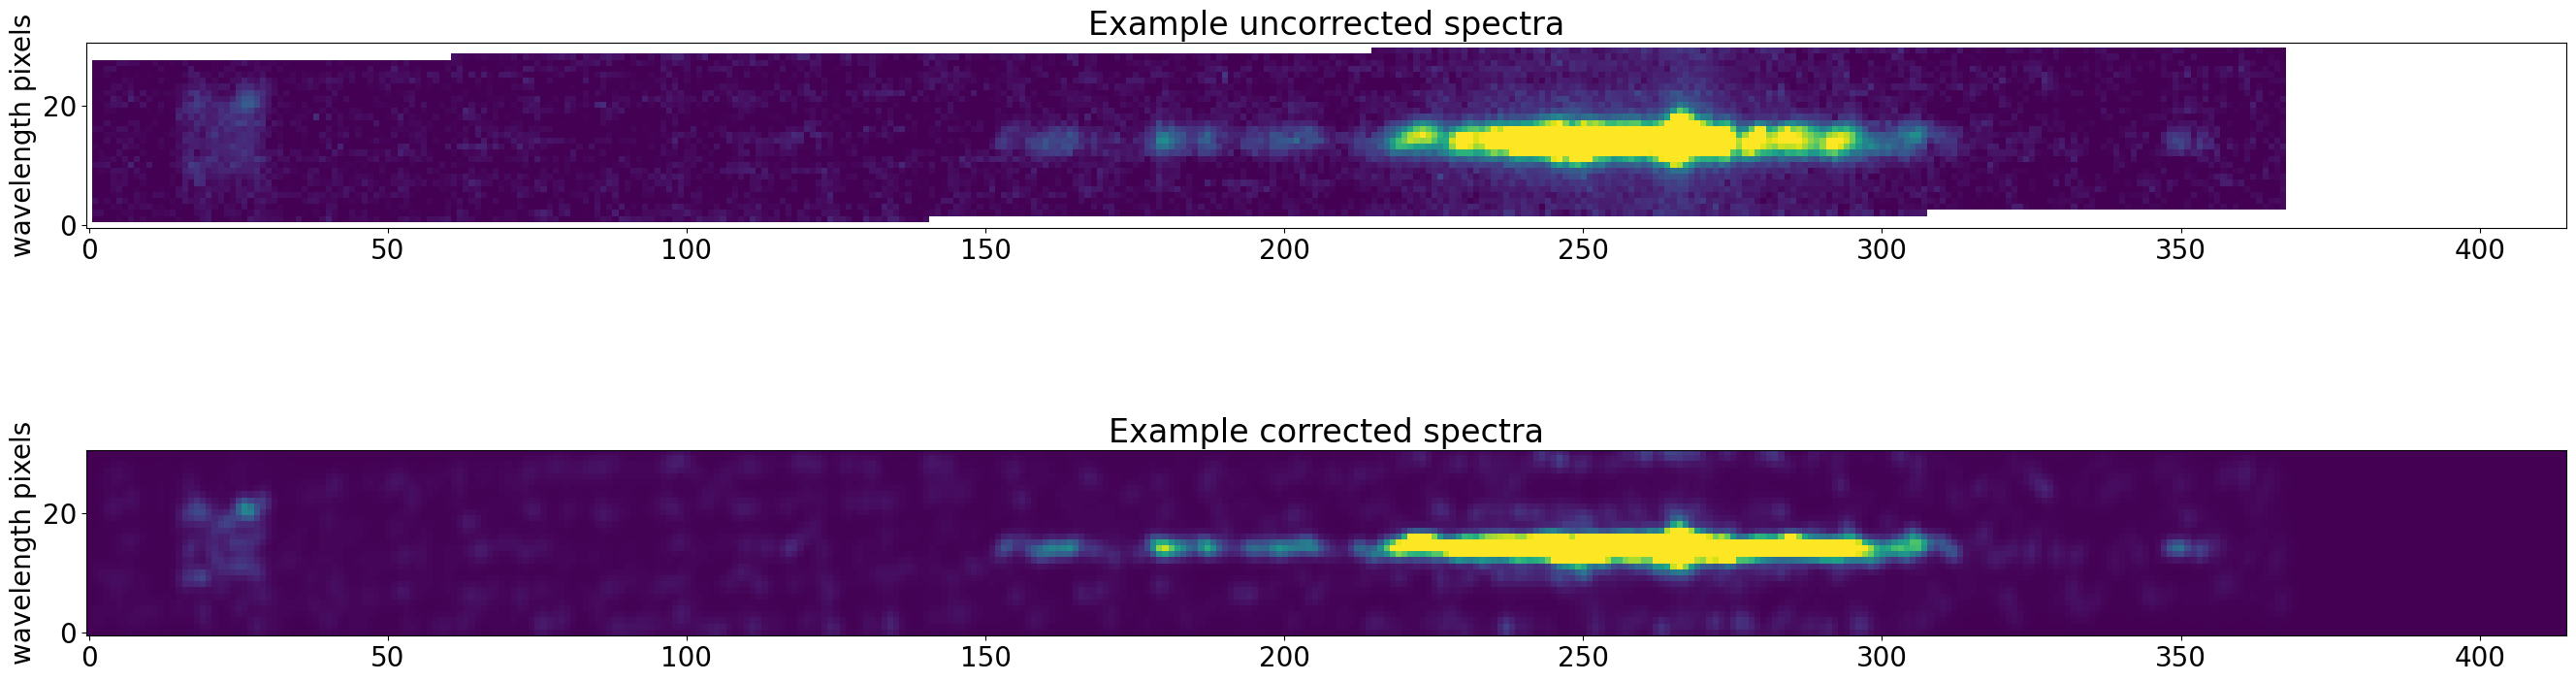

In [19]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=[33,10])
axes[0].imshow(spice_dat1[55,:,:].T,vmin=0,vmax=10)
axes[0].set(title='Example uncorrected spectra',ylabel='wavelength pixels')
axes[1].imshow(spice_corr_dat[55,:,:].T,vmin=0,vmax=10)
axes[1].set(title='Example corrected spectra',ylabel='wavelength pixels')

In [20]:
# Do some line fits for illustrative purposes:

spice_sdev_guess = 0.1 # Guess for standard deviation Gaussian fit to the uncorrected line profiles
corr_sdev_guess = 0.05 # Guess for standard deviation Gaussian fit to the corrected line profiles
## Estimate errors and mask off nonusable data points:
spice_mask, spice_err = get_mask_errs(spice_dat1.astype(np.float64), spice_err_fac)
spice_corr_mask, spice_corr_err = get_mask_errs(spice_corr_dat, spice_err_fac)

# Wavelength scale parameters, etc for the fitting output
[det_origin0,det_dims0,det_scale0] = [metadict['det_origin0'], metadict['det_dims0'], metadict['det_scale0']]
spice_la = (det_origin0[2]+det_scale0[2]*np.arange(det_dims0[2]))/platescale_l
spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,50:350,:],axis=(0,1)))]

# Fit the original spectra:
spice_fits = fsl(spice_dat1, spice_err, spice_la, spice_mask, spice_wlcen0, spice_sdev_guess)

# Fit the corrected spectra:
spice_corr_fits = fsl(spice_corr_dat, spice_corr_err, spice_la, spice_corr_mask, spice_wlcen0, spice_sdev_guess)

/tmp/ipykernel_483189/14268709.py:12: RuntimeWarning: Mean of empty slice
  spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,50:350,:],axis=(0,1)))]


0 of 128 0.0
6 of 128 0.0
12 of 128 0.0
18 of 128 0.0
24 of 128 0.0
30 of 128 0.0
36 of 128 0.0
42 of 128 0.0
48 of 128 0.0
54 of 128 0.0
60 of 128 0.0
66 of 128 0.0
72 of 128 0.0
78 of 128 0.0
84 of 128 0.0
90 of 128 0.0
96 of 128 0.0
102 of 128 0.0
108 of 128 0.0
114 of 128 0.0
120 of 128 0.0
126 of 128 0.0
127 of 128 0.0
0 of 128 0.0
6 of 128 0.0
12 of 128 0.0
18 of 128 0.0
24 of 128 0.0
30 of 128 0.0
36 of 128 0.0
42 of 128 0.0
48 of 128 0.0
54 of 128 0.0
60 of 128 0.0
66 of 128 0.0
72 of 128 0.0
78 of 128 0.0
84 of 128 0.0
90 of 128 0.0
96 of 128 0.0
102 of 128 0.0
108 of 128 0.0
114 of 128 0.0
120 of 128 0.0
126 of 128 0.0
127 of 128 0.0


In [21]:
# Update the estimated wavelength center
dopps = spice_corr_fits['centers'][50:350,:]
amps = spice_corr_fits['amplitudes'][50:350,:]
spice_wlcen = np.median(dopps[amps > np.mean(amps)])

[Text(0.5, 1.0, 'Corrected SPICE'),
 Text(0.5, 0, 'Slit scan microns (SPICE-equivalent)')]

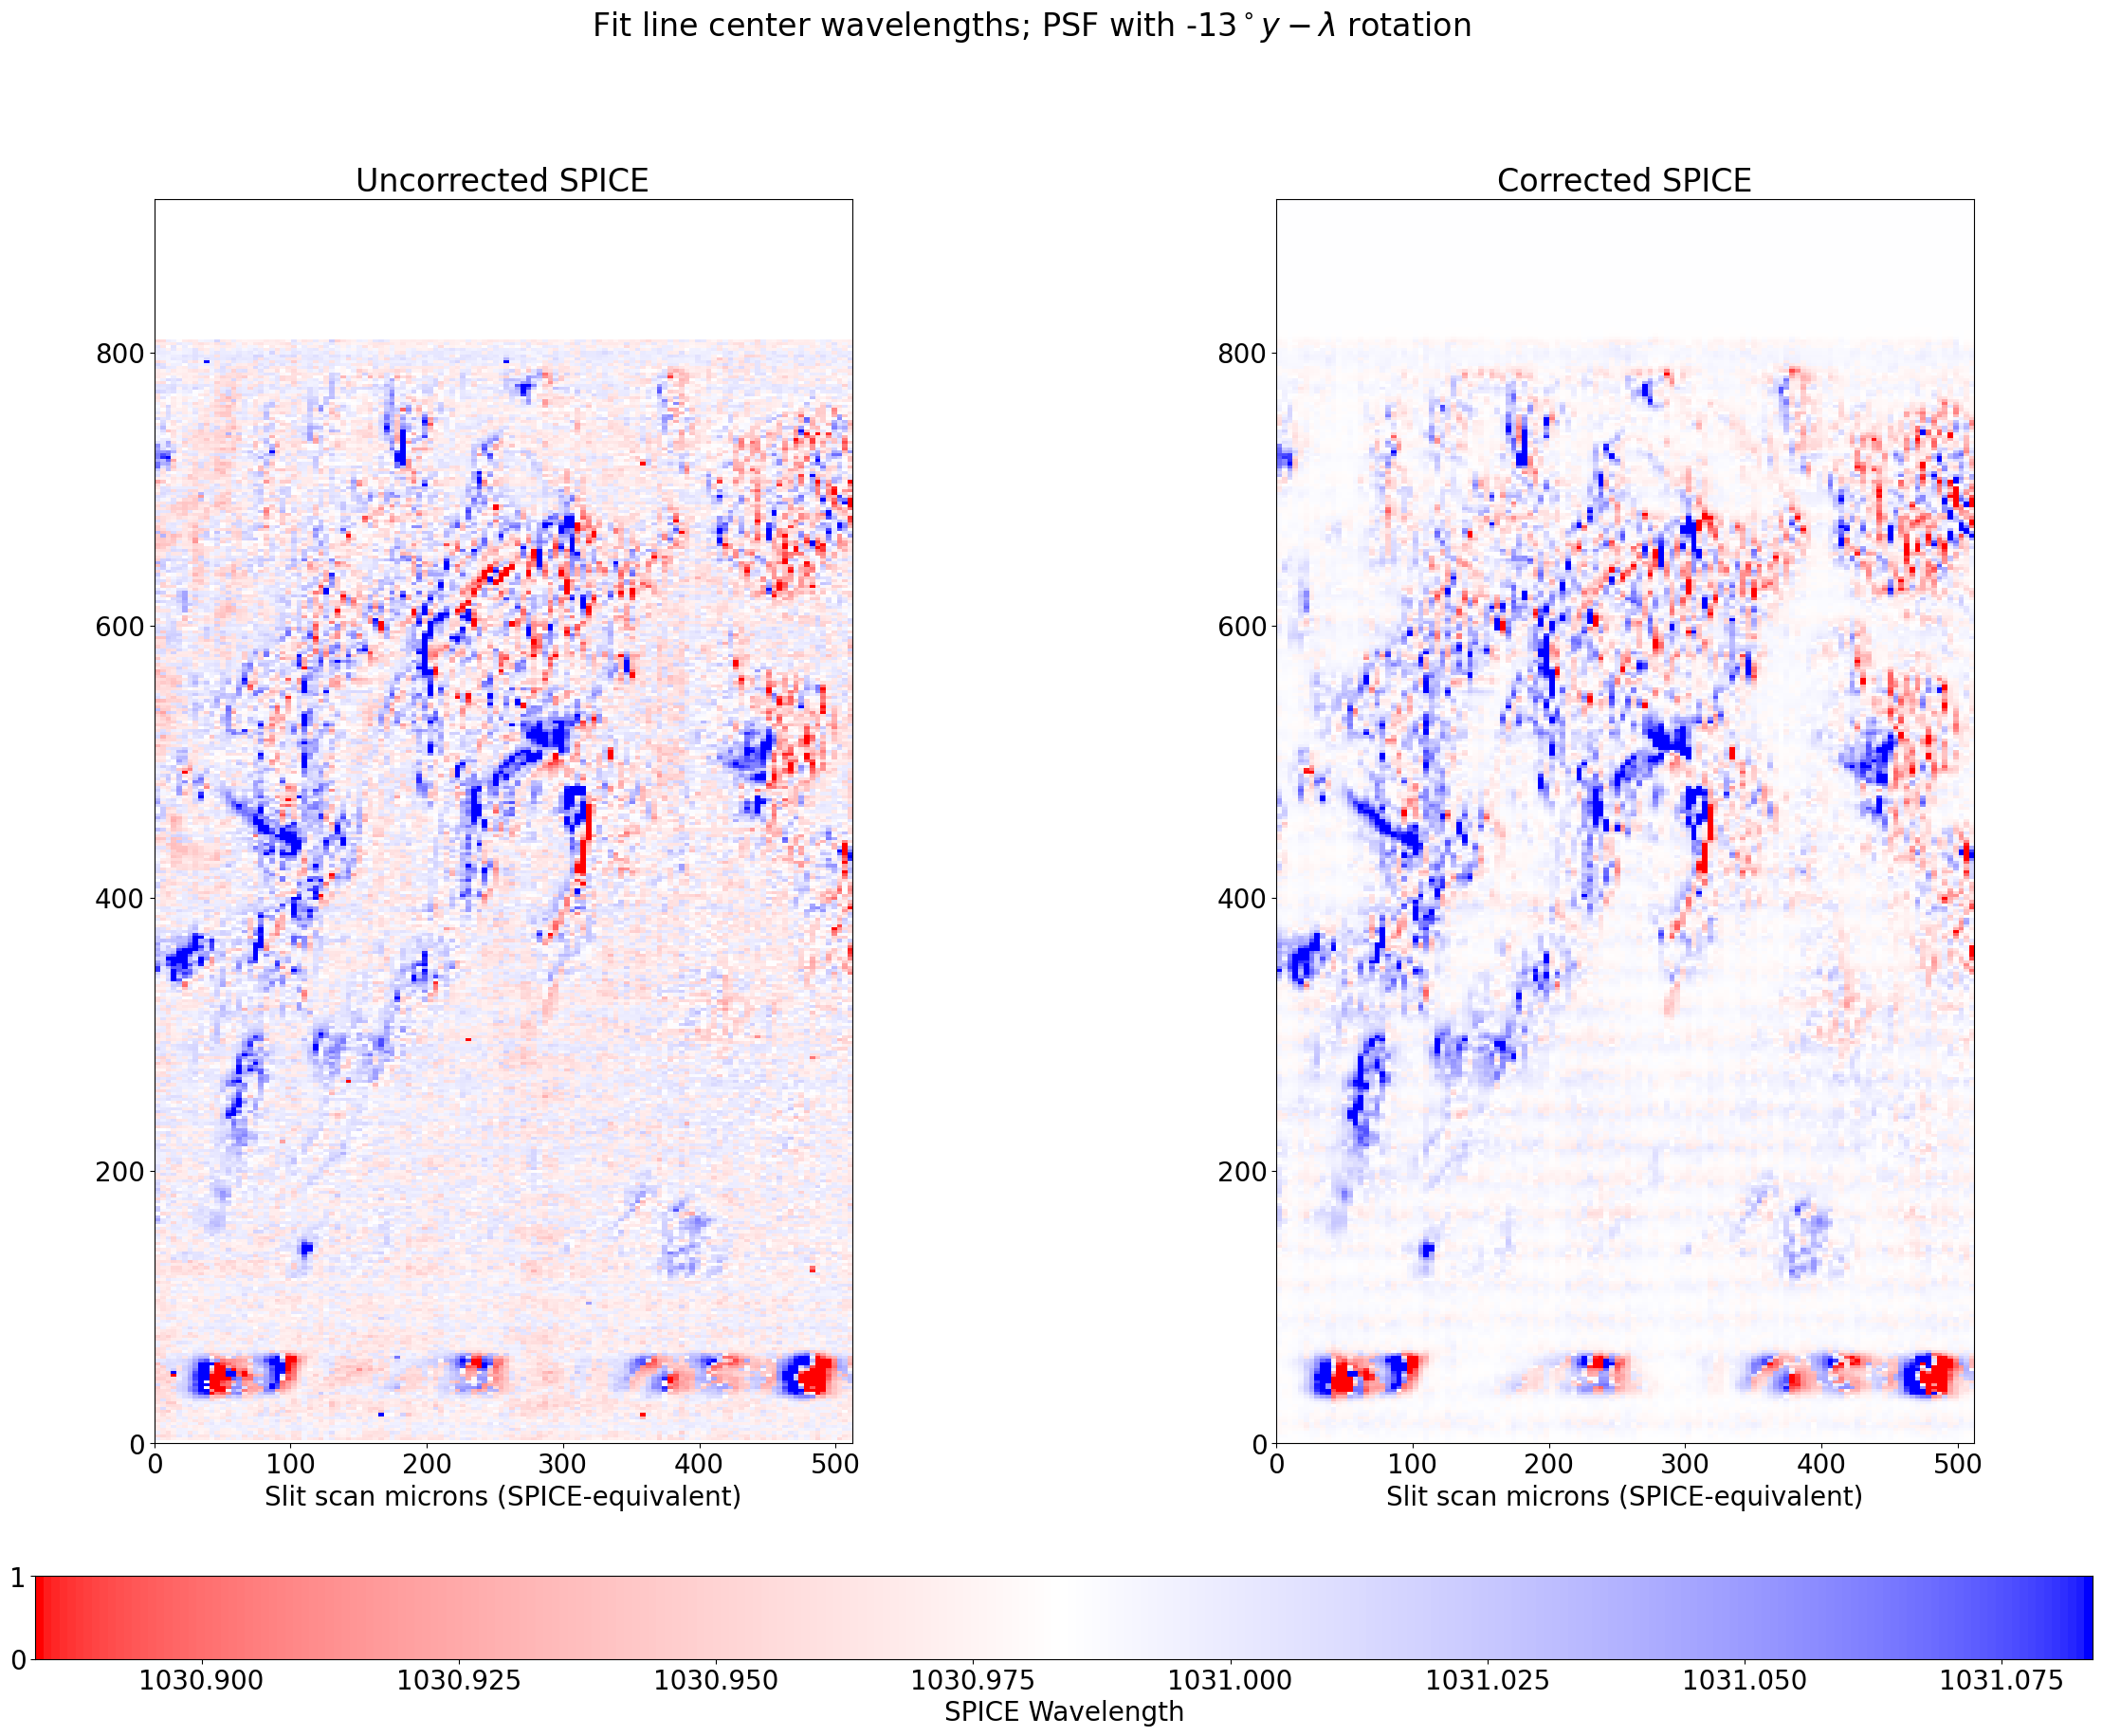

In [22]:
# Plot Doppler shifts. Fits and corrected data with low SNR (<100 across all 30 wavelengths) are unreliable and are attenuated to prevent
# them from being distracting.

gfac = 1.0/2.2
[det_origin0,det_dims0,det_scale0] = [metadict['det_origin0'], metadict['det_dims0'], metadict['det_scale0']]

yl_angle_str = str(round(psf_yl_angle*180/np.pi)).zfill(3)+r'$^\circ y-\lambda$ rotation'
def color_dopp_img(dopp,vmin,vmax,mask):
    dscal = np.clip(2*(dopp-(vmin+vmax)*0.5)/(vmax-vmin),-1,1)
    return 1.0-(mask*np.abs(np.array([np.clip(dscal,0,1),np.clip(dscal,-1,1),np.clip(dscal,-1,0)]))).transpose([1,2,0])

fig = plt.figure(figsize=[28,20])
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[15, 1])
fig.suptitle('Fit line center wavelengths; PSF with '+yl_angle_str)

spice_ext = np.array([0,det_dims0[0]*det_scale0[0],0,det_dims0[1]*det_scale0[1]])/platescale_y


cbaxis = fig.add_subplot(gs[1,:])
dopmin,dopmax = spice_wlcen+np.array([-0.1,0.1])
cbimg = np.outer(np.ones(5),np.linspace(-1,1,255))
cbaxis.imshow(color_dopp_img(cbimg,-1,1,np.ones(cbimg.shape))**gfac,extent=[dopmin,dopmax,0,1],aspect='auto')
cbaxis.set(xlabel='SPICE Wavelength')

for i in range(0,gs.ncols): 
    if(i==0): axes = []
    axes.append(fig.add_subplot(gs[0,i]))

iris_dopmin_offset = 0.0
iris_dopmax_offset = 0.0

# Compute SNRs and attenuation factors:
snr_corr = np.clip(np.nansum(spice_corr_dat**2/spice_corr_err**2,axis=2),0,100)/100
snr_orig = np.clip(np.nansum(spice_dat1**2/spice_err**2,axis=2),0,100)/100
#snr_mask = (np.nansum(spice_corr_dat**2/spice_corr_err**2,axis=2) >= 5)*(np.nansum(spice_dat1**2/spice_err**2,axis=2) >= 5)

axes[0].imshow(color_dopp_img(spice_fits['centers'].T,dopmin+iris_dopmin_offset,dopmax+iris_dopmax_offset,snr_orig.T)**gfac, extent = spice_ext)
axes[0].set(title='Uncorrected SPICE', xlabel='Slit scan microns (SPICE-equivalent)')

axes[1].imshow(color_dopp_img(spice_corr_fits['centers'].T,dopmin+iris_dopmin_offset,dopmax+iris_dopmax_offset,snr_corr.T)**gfac, extent = spice_ext)
axes[1].set(title='Corrected SPICE', xlabel='Slit scan microns (SPICE-equivalent)')

In [23]:
# Write the corrected spectra back to fits. Note the original header is used 
# is not updated to reflect the rebinning; this is just for a basic demonstration
# of function. This will error out if the test_output.fits file is already present.
# Pass overwrite=True to override this behavior.
fits.writeto(os.path.join(output_path,'test_ouput.fits'), spice_corr_dat, header=spice_hdr)